### This Python - Juptyer Notebook reads in raw pressure transducer data from the Rancho Venada site and converts to useful timeseries data


## Contact: Jesse Hahm, wjhahm -at- berkeley.edu or David Dralle, david.dralle -at - csus.edu

#### Last updated: Feb 2019

# Requirements for script execution:
Juptyer / Python, access to Berkeley Sensor Database (contact Collin Bode), raw data download files (CSV exports from Solinst Levelogger software), in folder: "Data\\manualDownloads\\", Well metadata file (in this folder)



# Description of output datasets:

*The file you probably want is:*

https://github.com/jessehahm/Sagehorn-Well-Stream-Public/raw/master/Data/Output/level4e.csv

See details below

## (outputs are in the folder "Data\\Outputs")
## For column header information and more, look in metadata.csv!!!

* compiled_raw_data.csv

This file is the compiled data for each sensor, merged into one. LEVEL is pressure (kPa), temp is temperature (degrees C) The header numbers refer to the sensor serial number. See metadata.csv for the key!

* level1.csv: 

this is essentially the same as compiled_raw_data.csv, but has been trimmed to exclude times prior to sensor deployment and the column headers are replaced by the level1 DSID (data stream ID) (key in metadata.csv)

* level4a.csv:

This data has is the same as level1.csv, but has had atmospheric pressure subtracted (from the Sagehorn weather station, with gap-filled data from Cahto Pk barometer when Sagehorn barometer broken (+/- 2 cm water equiv. 95% confidence, see accompanying notebook)). Creek sensors have an additional offset subtracted, because they are lower in elevation (more pressure) than the wells/weather station, which are all about the same elevation

A 'Flag Bad Pressure Sensor' column is added, marked 'True' if the Sagehorn weather station barometer was broken - these values

* level4b.csv:

This is the same as level4a.csv, but the pressures have have been converted into equivalent height of water column above the sensor

* level4c.csv:

This is the same as level4b.csv, but height of water column above sensor has been converted to depth to water table from surface [m] (for the wells) or stage height [m] (for the streams). One-time offsets in the streams have been corrected when the relative location of the transducer was changed (for example when direct read cables were installed)

* level4d.csv:

Same as level4d.csv, but discharge has been calculated for Dry Creek (this is subject to change as rating curve changes; see accompanying stage-discharge notebook) and column headers have been renamed to human-readable, descriptive titles!



** not implemented, but code included (see commented out cell below): an optional median rolling window outlier detection algorithm, to automate removal of times when sensors were removed from well/stream (for data download, other sampling, etc) **


* level4e.csv:

Same as level4d.csv, but timeseries has been resampled to uniform 15 minute minute intervals (using median),  new columns (water year) is added, and water-year cumulative dry Runoff (mm) is also included. 

Also included in level4e is a wind-induced undercatch precipitation correction  following Yang et al 1998 (see accompanying notebook) who provide correction eqns as f(wind speed) for our TB-4 8" diam tipping bucket gauge and a combined wind and canopy interception correction (following liao et al 2001 ) 
(for sagehorn, angelo meadow, and cahto peak) and water-year cumulative corrected precip,

Column order is sorted alphabetically to help maintain consistency

In [1]:
# Import required libraries

import re
import glob
# import readData
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = "Arial"
import pandas as pd
import numpy as np
import functools
%matplotlib inline
from math import isnan
import functools
import csv
import itertools
import ulmoQuery
import fiona
import geopandas as gp
import rasterio

/Users/daviddralle/anaconda2/envs/py3k/lib/python3.5/site-packages/ulmo/twc/kbdi/core.py:20: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  CSV_SWITCHOVER = pandas.tslib.Timestamp('2016-10-01')


In [9]:
# Read in metadata
metadataFile = 'Data/metadata.csv'
metadata = pd.read_csv(metadataFile,sep=',', dtype=str)
metadata = metadata.set_index('SERIAL')

In [3]:
#function to read in raw sensor data
def readCSV(allFiles, types=['WELL', 'PIEZOMETER']):
    dfs = []
    allSerials = []
    for i, file_ in enumerate(allFiles):
        #append each manually downloaded file as a pandas dataframe to the list dfs
        # get number of rows before header
        with open(file_, encoding="utf8", errors='ignore') as f:
            reader = csv.reader(f)
            for j,row in enumerate(reader):
                if len(row)==0: continue
                if 'Date' == row[0]:
                    skiprows=j
                    break

        thisFile = pd.read_csv(str(file_),sep=',',  skiprows = skiprows)
        #some got started at 27 seconds after the hour, fix this
        thisFile['Time'] = thisFile['Time'].str.replace(':27',':00')
        thisFile['datetime'] = pd.to_datetime(thisFile['Date'] + ' ' + thisFile['Time'])
        thisFile.drop(['Date'],inplace=True,  axis=1)
        thisFile.drop(['Time'],inplace=True,  axis=1)
        thisFile['datetime'] =  pd.to_datetime(thisFile['datetime'], dayfirst=True)
        thisFile.set_index(['datetime'], drop=True, inplace=True)
        if 'ms' in thisFile.columns:
            thisFile = thisFile.drop('ms', axis=1)
        #separately figure out what the serial # of each sensor is (to match files together)
        with open(file_, encoding="utf8", errors='ignore') as f:
            reader = csv.reader(f)
            serial = next(itertools.islice(reader, 1, None))[0]
        if serial not in metadata.index.tolist():
            continue
        if metadata.loc[serial].TYPE not in types:
            continue
            
        #Rename the columns by appending the serial name
        thisFile.rename(columns={'LEVEL': str(serial) + '_LEVEL' }, inplace=True)
        thisFile.rename(columns={'TEMPERATURE': str(serial) + '_TEMPERATURE' }, inplace=True)
        allSerials.append(serial)
        dfs.append(thisFile)
    completeTimeseries = []
    #Now, for each unique serial number:
    for serial in set(allSerials):
        #Find the indices of the data frames list (dfs) to get its dataframes
        indices = [i for i, x in enumerate(allSerials) if x == serial]
        thisSerialFiles = [dfs[i] for i in indices]
        
        #Join all files of the same sensor (same serial number)

        #concatenate
        oneSerial = pd.concat(thisSerialFiles)
        #drop duplicates
        oneSerial = oneSerial[~oneSerial.index.duplicated(keep='first')]
        #sort
        oneSerial.sort_index(inplace = True)
        completeTimeseries.append(oneSerial)
    #Join all sensors together
    merge = functools.partial(pd.merge, left_index=True, right_index=True, how='outer')
    data = functools.reduce(merge, completeTimeseries)
    return data

In [4]:
# Pressure data file locations
allFiles = glob.glob('Data/manualDownloads/*.csv') #get all files with csv extension in this subfolder
data = readCSV(allFiles)

In [5]:
# for column in data.columns: 
#     plt.plot(data.index, data[column])
#     plt.title(column)
#     plt.show()

In [6]:
#output data
data.to_csv('./Data/Output/compiled_raw_data.csv')

In [7]:
## Trim 
#date-time range of interest
#pressure transducers installed 11/25, 11/26 2015
startDateTime = pd.to_datetime('2018-11-16 00:00:00')
stopDateTime = pd.to_datetime('2020-12-01 00:00:00')
data_timeRange = data.loc[startDateTime:stopDateTime]


In [8]:
def dictionary(df, keys, values): 
    """Create dictionary from columns of dataframe
    df: dataframe:
    keys: key column name
    values: value column name"""
    d = dict(zip(df[keys], df[values]))
    d.pop(np.nan, None)
    return d

In [15]:
# Read in metadata

metadataFile = 'Data/metadata.csv'
metadata = pd.read_csv(metadataFile,sep=',', dtype=str)
metadata.MANUAL_DEPTH_TIMESTAMP = pd.to_datetime(metadata.MANUAL_DEPTH_TIMESTAMP)

#Create dictionaries
serial_TempDSID = dictionary(metadata, 'SERIAL', 'Temperature [deg C] DSID') 
serial_rawPressureDSID = dictionary(metadata, 'SERIAL', 'raw Pressure [kPa] DSID') 
raw_atmCorrectedPressureDSID = dictionary(metadata, 'raw Pressure [kPa] DSID', 'atm corrected Pressure [kPa] DSID') 
atmCP_heightWater = dictionary(metadata, 'atm corrected Pressure [kPa] DSID', 'height of water column [m] DSID') 
atmCP_wellID = dictionary(metadata, 'atm corrected Pressure [kPa] DSID', 'WELL ID') 
heightWater_depthFromStickup = dictionary(metadata, 'height of water column [m] DSID', 'Depth from inner-stickup / Stage [m] DSID') 
depthFromStickup_depthCorrection = dictionary(metadata, 'Depth from inner-stickup / Stage [m] DSID', 'DEPTH OF PRESSURE TRANSDUCER SENSOR FROM INNER PVC STICKUP (m) (2016-01-07 manual measurement correction)') 
depthFromGroundSurface_depthCorrection = dictionary(metadata, 'Depth from inner-stickup / Stage [m] DSID', 'Transducer Depth From Ground Surface (m)') 
depthFromStickup_type = dictionary(metadata, 'Depth from inner-stickup / Stage [m] DSID', 'TYPE') 
depthFromStickup_ID = dictionary(metadata, 'Depth from inner-stickup / Stage [m] DSID', 'WELL ID') 
temp_ID = dictionary(metadata, 'Temperature [deg C] DSID', 'WELL ID') 


In [17]:
## Map sensor serial number and type of observation to raw data DSID
level1 = data_timeRange.copy()
for col in level1.columns:
    serial = col.split('_')[0]
    if 'LEVEL' in col:
        level1.rename(columns={col: serial_rawPressureDSID[str(serial)]}, inplace=True)
    if 'TEMPERATURE' in col:
        level1.rename(columns={col: serial_TempDSID[str(serial)]}, inplace=True)
        
level1.to_csv('./Data/Output/level1.csv')

# Get elevations for each of the wells/piezos

In [93]:
pts = gp.read_file('./Data/GIS/rv_pts.kml')
pts['x'], pts['y'] = pts.geometry.apply(lambda val: val.x), pts.geometry.apply(lambda val: val.y)
src = rasterio.open('./Data/GIS/dem.tif')
pts['elevation'] = [val[0] for val in src.sample(pts.apply(lambda val: (val.x, val.y), axis=1))]
pts = pts[['Name', 'x', 'y', 'elevation']]

In [94]:
file_ = './Data/manualDownloads/mh3tree.csv'
with open(file_, encoding="utf8", errors='ignore') as f:
    reader = csv.reader(f)
    for j,row in enumerate(reader):
        if len(row)==0: continue
        if 'Date' == row[0]:
            skiprows=j
            break

# pressure in kPa
atmP = pd.read_csv(str(file_),sep=',',  skiprows = skiprows)
atmP['P_mh3tree'] = atmP.LEVEL
atmP['datetime'] = pd.to_datetime(atmP['Date'] + ' ' + atmP['Time'])
atmP.drop(['Date', 'Time', 'ms', 'LEVEL'],inplace=True,  axis=1)
atmP['datetime'] =  pd.to_datetime(atmP['datetime'], dayfirst=True)
atmP.set_index(['datetime'], drop=True, inplace=True)

In [95]:
#join level1 with atmP
level1_atmP = atmP.merge(level1,left_index=True, right_index=True,how='inner')

In [55]:
#Construct Level 4 Data (Derived Data, from Multiple Variables or from a Model)
# temperature does not change, but atmospheric pressure correction occurs
# level 4a: subtracted atmospheric pressure
# level 4b: converted to depth of water overburden above sensor
# level 4c: converted to stage height and/or depth of water from surface


# Subtract atmospheric pressure 
level4a = level1.copy()
level4a.index.name = 'Datetime UTC - 8'
level4a.rename(columns=raw_atmCorrectedPressureDSID, inplace=True)
# Subtract atmospheric pressure (in mbar from met station dsid 2958)
for col in level4a.columns:
    if col in raw_atmCorrectedPressureDSID.values():
        #mbar to kpa: divide by 10
        
        ##### CHOOOSE WHICH ATMOSPHERIC PRESSURE TO SUBTRACT! ####
        level4a[col] = level4a[col] - (level1['SagehornP']/10.0) # on ridge
#         level4a[col] = level4a[col] - level4a['8105'] # in well 505
        
        #flag streams/flume; subtract different amount to account for elevation pressure difference
        if atmCP_wellID[col] == 'DRY':
            #Subtract extra elevation pressure here 
            level4a[col] = level4a[col] - 0.924 #kPa difference between ridge/stream (Dry)
        if atmCP_wellID[col] == 'HANK':
            #Subtract extra elevation pressure here 
            level4a[col] = level4a[col] - 1.12 #kPa difference between ridge/stream (Hank)
            # (plot level4 versus time and look for when sensor pulled out of water to check this difference)
            # or see comparison in accompanying barometric pressure notebook 
        if atmCP_wellID[col] == 'MS-FLUME':
            #Subtract extra elevation pressure here 
            level4a[col] = level4a[col] - 0.42 #kPa difference between ridge/stream (Hank)
            # (plot level4 versus time and look for when sensor pulled out of water to check this difference)
            # or see comparison in accompanying barometric pressure notebook 
    
#Convert from height of water level above pressure transducer to depth below ground surface    
level4a.drop(['SagehornP'],inplace=True,  axis=1)
level4a.drop(['CahtoP'],inplace=True,  axis=1)


In [56]:
level4a.to_csv('Data\Output\level4a.csv')

In [57]:
# convert to height of water column above sensor in meters
level4b = level4a.copy()
level4b.rename(columns=atmCP_heightWater, inplace=True)
for col in level4b.columns:
    if col in atmCP_heightWater.values():
        level4b[col] = (level4b[col] * 10.1972)/100.0 #kpa to m h20
#join wells 500,501,502
level4b=level4b.merge(well500level,left_index=True, right_index=True,how='left')
level4b=level4b.merge(well501level,left_index=True, right_index=True,how='left')
level4b=level4b.merge(well502level,left_index=True, right_index=True,how='left')

level4b = level4b[~level4b.index.duplicated(keep='first')]

level4b.to_csv('Data\Output\level4b.csv')


In [58]:
# create depth from surface [m] column (wells) or stage height (streams)
level4c = level4b.copy()
level4c.rename(columns=heightWater_depthFromStickup, inplace=True)
for col in level4c.columns:
    #if pressure, not temperature
    if col in heightWater_depthFromStickup.values():
        #if a well
        if depthFromStickup_type[col] == 'WELL':
            level4c[col] = -(float(depthFromStickup_depthCorrection[col]) - level4c[col])
        if depthFromStickup_type[col] == 'PIEZOMETER':
            level4c[col] = -(float(depthFromGroundSurface_depthCorrection[col]) - level4c[col])
        
        #if a stream
        # transducer locations in stilling wells have changed due to silt in-filling
        # and transition to direct-read cables. 
        # here we translate height of water column to stage height for specific time periods
        if depthFromStickup_ID[col] == 'DRY':
            #Pre-installation of direct-read cable
            level4c[col] = level4c[col] + 0.12
            #Post-installation of direct-read cable
            level4c.loc[(level4c.index >= pd.to_datetime('2016-01-07 16:30:00')),col] = level4c[col] - 0.07
  
        if depthFromStickup_ID[col] == 'HANK':
            #Pre-installation of direct-read cable
            level4c[col] = level4c[col] + 0.03
            #Pre-installation of direct-read cable; post silt-filling adjustment
            level4c.loc[(level4c.index > pd.to_datetime('2015-12-10 11:20:00')) ,col] = level4c[col] + 0.3
            #Post-installation of direct-read cable
            level4c.loc[(level4c.index >= pd.to_datetime('2016-01-05 17:00:00')),col] = level4c[col] - 0.04

level4c['WELL 500 (Water level from surface (m))'] = (level4c['well500level']-7.957+0.149)
level4c['WELL 501 (Water level from surface (m))'] = (level4c['well501level']-13.481)
level4c['WELL 502 (Water level from surface (m))'] = (level4c['well502level']-6.208+0.141)

level4c.drop(['well500level'],inplace=True,  axis=1)
level4c.drop(['well501level'],inplace=True,  axis=1)
level4c.drop(['well502level'],inplace=True,  axis=1)

            
level4c.to_csv('Data\Output\level4c.csv')

In [59]:
#Calculate dry discharge
# See associated notebook for polynomial coefficients and where flow goes to 0
#Piece-wise fit for high/low flows
level4c['dryDischarge_m3s^-1'] = 0

level4c['dryDischarge_m3s^-1'] = np.where(level4c['9012']>=0.2,
                                   np.exp(-5.07713153*(np.log(level4c['9012'])**2) + 
                                  (0.4484192 *np.log(level4c['9012']))+
                                     1.47924463),
                                     0)
level4c['dryDischarge_m3s^-1'] = np.where(level4c['9012']>=0.8,
                                          np.exp(-0.29377786*(np.log(level4c['9012'])**2) + 
                                          (2.56692557*np.log(level4c['9012']))+
                                           1.71379793),
                                          level4c['dryDischarge_m3s^-1'])     

#                                   (0.07/0.425)*level4c['9012'])


level4c['dryRunoff_mmDay^-1'] = (level4c['dryDischarge_m3s^-1']/3459518.0)*1000*(60*60*24)
level4c['dryRunoff_mmHour^-1'] = level4c['dryRunoff_mmDay^-1']/24.0
level4c['dryRunoff_cmHour^-1'] = level4c['dryRunoff_mmHour^-1']/10


/Users/jh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/Users/jh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


In [60]:
# Calculate MS-FLUME discharge and runoff
#3" parshall flume
level4c['MS-FLUME-Discharge_m3s^-1'] = 0

# level4c['MS-FLUME-Discharge_m3s^-1'] = np.where(level4c['9021']>=0.0,
#                                        0.1765*level4c['9021']**1.55,
#                                        0)
level4c['MS-FLUME-Discharge_m3s^-1'] = np.where(level4c['9021']>=0.0,
                                       (176.5/1000)*((level4c['9021'])**1.55),
                                       0)
flume_catchment_area = 22773.0 #m2
level4c['MS-FLUME-Runoff_mmDay^-1'] = (level4c['MS-FLUME-Discharge_m3s^-1']/flume_catchment_area)*1000*(60*60*24)
level4c['MS-FLUME-Runoff_mmHour^-1'] = level4c['MS-FLUME-Runoff_mmDay^-1']/24.0
level4c['MS-FLUME-Runoff_cmHour^-1'] = level4c['MS-FLUME-Runoff_mmHour^-1']/10



In [61]:
# LEVEL 4D
# renamed columns and discharge added
level4d = level4c.copy()

for col in level4d.columns:
    #if temperature
    if col in serial_TempDSID.values():
        level4d.rename(columns={col: temp_ID[col]+ ' (temp (degC))'}, inplace=True)
    if col in depthFromStickup_ID:
        if depthFromStickup_type[col]=='WELL':
            level4d.rename(columns={col: 'WELL ' + depthFromStickup_ID[col] + ' (Water level from surface (m))'}, inplace=True) 
        if depthFromStickup_type[col]=='STREAM':
                        level4d.rename(columns={col: 'CREEK ' + depthFromStickup_ID[col] + ' stage (m)'}, inplace=True) 
        if depthFromStickup_type[col]=='PIEZOMETER':
                        level4d.rename(columns={col: 'PIEZOMETER ' + depthFromStickup_ID[col] + ' (Water level from surface (m))'}, inplace=True) 
        if depthFromStickup_type[col]=='FLUME':
                        level4d.rename(columns={col: 'FLUME ' + depthFromStickup_ID[col] + ' stage (m)'}, inplace=True) 



In [62]:
level4d.to_csv('Data\Output\level4d.csv')
level4d.tail()

,Flag Bad Pressure Sensor,PIEZOMETER MNP1 (Water level from surface (m)),MNP1 (temp (degC)),WELL 507 (Water level from surface (m)),507 (temp (degC)),FLUME MS-FLUME stage (m),MS-FLUME (temp (degC)),WELL MN-1 (Water level from surface (m)),MN-1 (temp (degC)),PIEZOMETER MSP2 (Water level from surface (m)),...,WELL 501 (Water level from surface (m)),WELL 502 (Water level from surface (m)),dryDischarge_m3s^-1,dryRunoff_mmDay^-1,dryRunoff_mmHour^-1,dryRunoff_cmHour^-1,MS-FLUME-Discharge_m3s^-1,MS-FLUME-Runoff_mmDay^-1,MS-FLUME-Runoff_mmHour^-1,MS-FLUME-Runoff_cmHour^-1
2018-08-09 11:30:00,False,-0.545119,25.508,NaN,NaN,NaN,NaN,-1.936349,17.2,NaN,...,-8.649,-1.866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-08-09 11:45:00,False,-0.545598,25.503,NaN,NaN,NaN,NaN,-1.936859,17.2,NaN,...,-8.648,-1.866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-08-09 12:00:00,False,-0.540291,25.498,NaN,NaN,NaN,NaN,-1.931614,17.2,NaN,...,-8.648,-1.866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-08-09 12:15:00,False,-0.546165,27.537,NaN,NaN,NaN,NaN,-1.930900,17.2,NaN,...,-8.648,-1.866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-08-09 12:30:00,False,NaN,NaN,NaN,NaN,NaN,NaN,-1.930186,17.2,NaN,...,-8.649,-1.866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


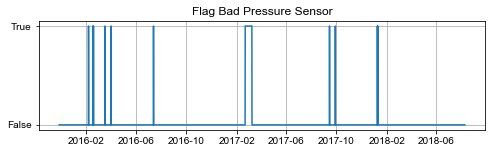

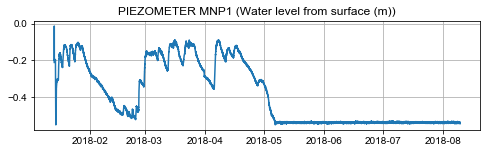

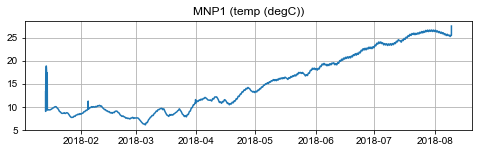

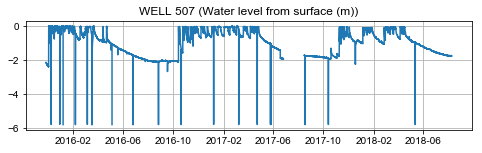

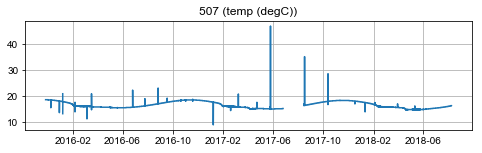

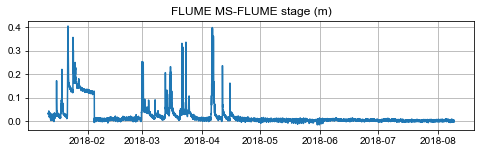

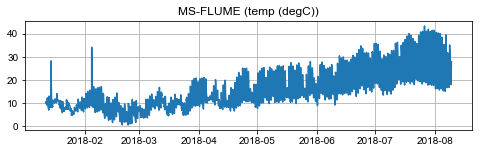

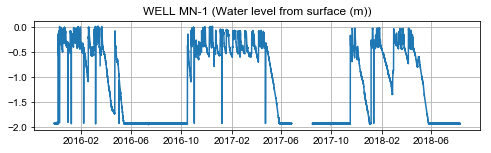

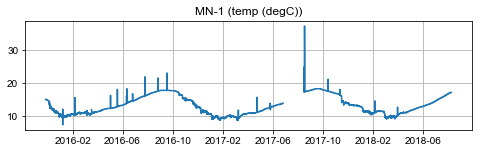

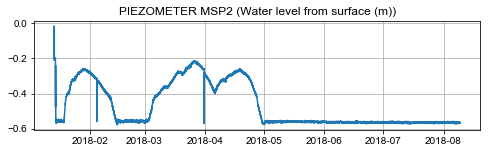

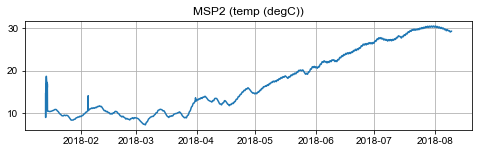

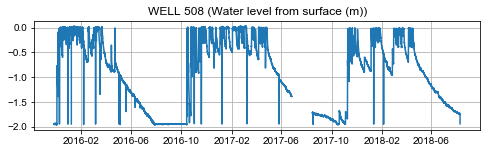

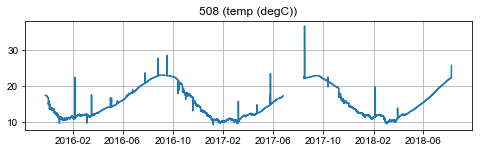

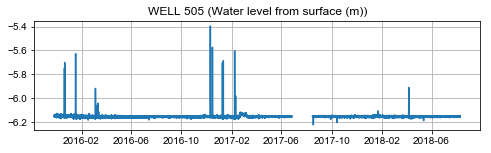

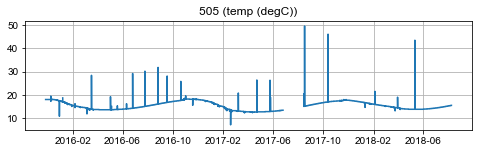

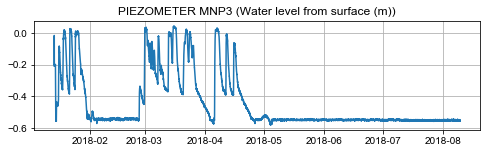

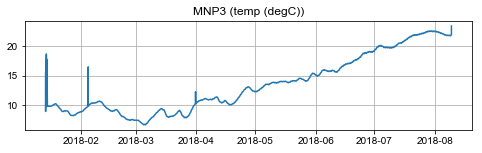

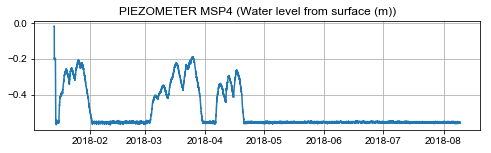

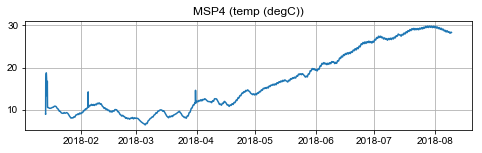

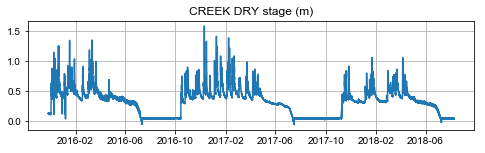

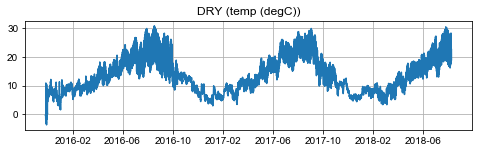

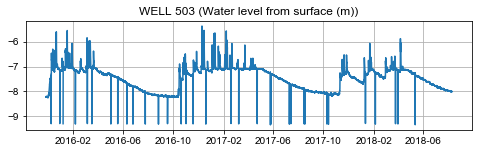

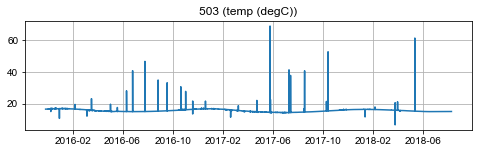

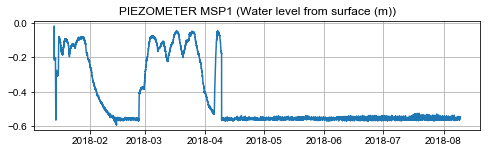

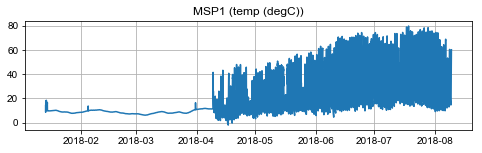

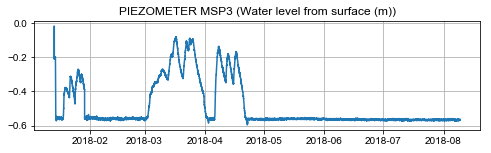

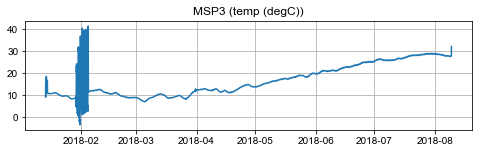

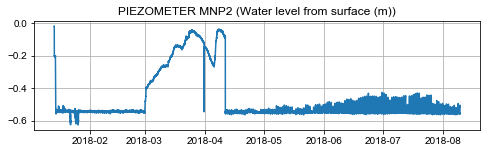

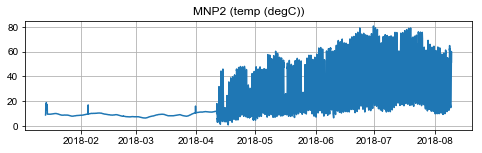

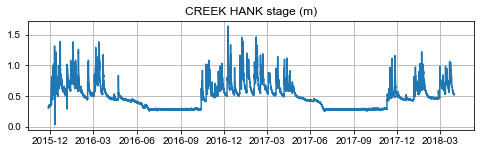

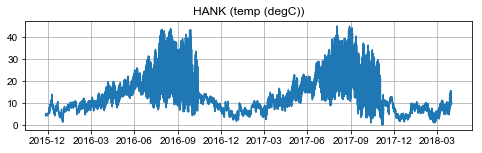

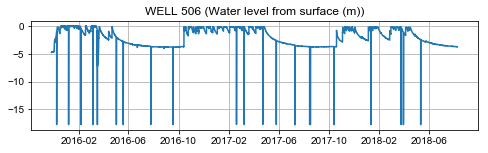

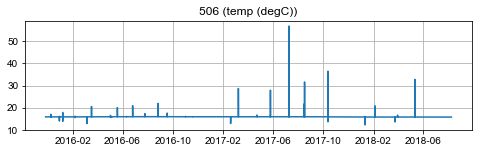

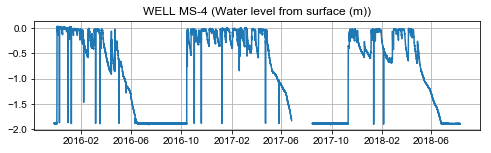

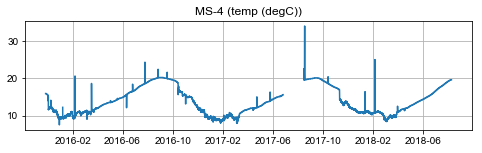

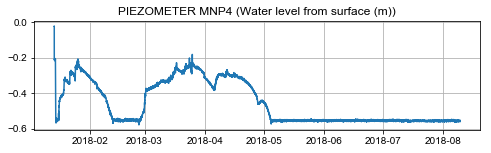

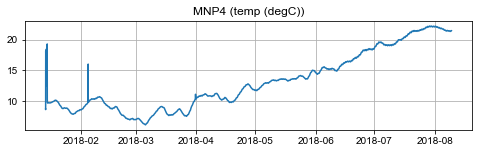

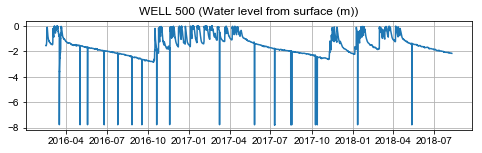

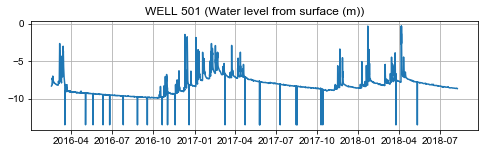

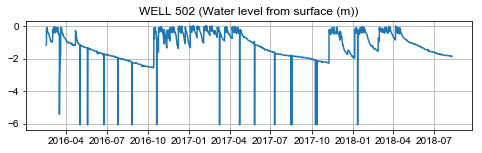

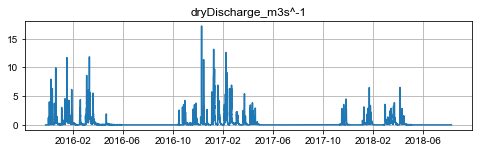

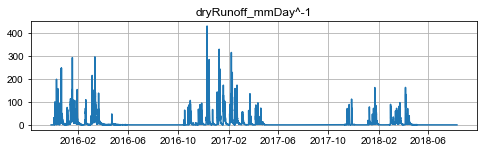

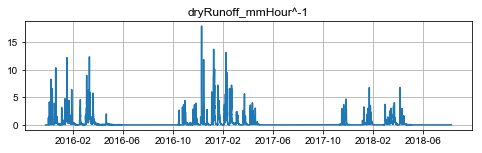

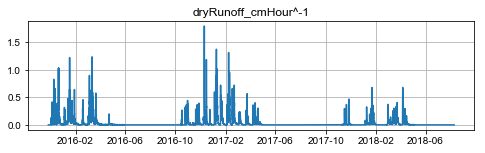

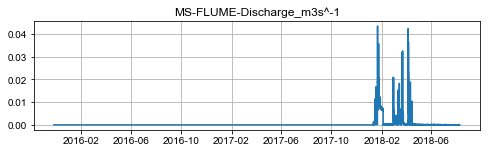

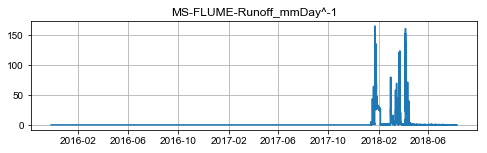

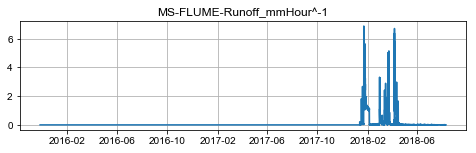

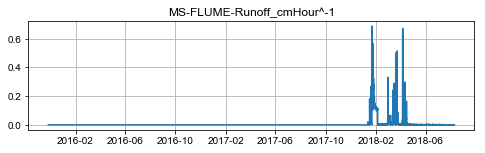

In [74]:
#diagnostic plots:
for column in level4d.columns: 
    plt.subplots(figsize=(8,2))
    plt.plot(level4d.index, level4d[column])
    plt.title(column)
    plt.grid()
#     plt.savefig('Data/Output/OutputFigures/'+column+'-allTime.pdf')
    plt.show()

In [63]:
# #OUTLIER DETECTION AND ELIMINATION WITH ROLLING MEDIAN FILTER
# #from python4oceanographers

# kw = dict(marker='o', linestyle='none', color='r', alpha=0.3)

# level4d['MS-4 (temp (degC))-median'] = pd.rolling_median(level4d['MS-4 (temp (degC))'], window=20, center=True).fillna(method='bfill').fillna(method='ffill')

# difference = np.abs(level4d['MS-4 (temp (degC))'] - level4d['MS-4 (temp (degC))-median'])
# outlier_2 = difference > 2
# outlier_3 = difference > 3
# outlier_10 = difference > 10


# fig, ax = plt.subplots()
# level4d['MS-4 (temp (degC))'].plot()
# level4d['MS-4 (temp (degC))'][outlier_2].plot(**kw)
# kw.update(color='g', marker='*', alpha=1)
# level4d['MS-4 (temp (degC))'][outlier_3].plot(**kw)
# kw.update(color='k', marker='*', alpha=1)
# level4d['MS-4 (temp (degC))'][outlier_10].plot(**kw)
# # _ = ax.set_ylim(-50, 60)

# level4d['MS-4 (temp (degC))'][~outlier_2].plot(**kw)


In [64]:
#ADD WIND=INDUCED UNDERCATCH CORRECTED PRECIP
merged = sagehornPrecip.merge(sagehornWind,left_index=True, right_index=True,how='inner')
merged = merged.merge(angeloWind,left_index=True, right_index=True,how='inner')
merged = merged.merge(cahtoWind,left_index=True, right_index=True,how='inner')
merged = merged.merge(angeloPrecip,left_index=True, right_index=True,how='inner')
merged = merged.merge(cahtoPrecip,left_index=True, right_index=True,how='inner')

#correct wind speed to height of rain gauge, assuming 0.1 m roughness layer
#Yang et al 1998 Accuracy of NWS 8" standard nonrecording precipitation gauge: Results and application of WMO intercomparison, J. Atmos. Oceanic Technol. , 15 , 54–68.
merged['sagehornWindSpeed_HeightAdjusted'] = (np.log(1.5/0.1)/np.log(3/0.1))*merged['sagehornWind']
merged['angeloWindSpeed_HeightAdjusted'] = (np.log(1.5/0.1)/np.log(3/0.1))*merged['angeloWind']
merged['cahtoWindSpeed_HeightAdjusted'] = (np.log(1.5/0.1)/np.log(3/0.1))*merged['cahtoWind']

merged['sagehornCFyang']=0.01*np.exp(4.605-0.062*merged['sagehornWindSpeed_HeightAdjusted']**0.58)
merged['sagehornPrecipUndercatchCorrected-mm']=merged['sagehornPrecip']/merged['sagehornCFyang']
merged['angeloCFyang']=0.01*np.exp(4.605-0.062*merged['angeloWindSpeed_HeightAdjusted']**0.58)
merged['angeloPrecipUndercatchCorrected-mm']=merged['angeloPrecip']/merged['angeloCFyang']
merged['cahtoCFyang']=0.01*np.exp(4.605-0.062*merged['cahtoWindSpeed_HeightAdjusted']**0.58)
merged['cahtoPrecipUndercatchCorrected-mm']=merged['cahtoPrecip']/merged['cahtoCFyang']



In [65]:

merged15min = merged.resample('15min', label='right').sum()


In [66]:
#To quantify canopy interception, which can significantly decrease the magnitude of rain that arrives at the ground surface, we account for an initial ‘wet-up’ period in which rain is captured in the canopy, after which throughfall is equal to the incoming rain intensity . We therefore subtract 1 or 4 mm from daily rainfall totals respectively from the winter-deciduous oak annual grass savanna (Dry Creek) or mixed needleleaf-broadleaf evergreen forest (Elder Creek); when less rain falls than these thresholds no effective precipitation occurs. 

# See e.g. Liao et al 2001; code modified from original function by David Dralle
def intercept_rain(df,precip_column, interception_depth):
    freq = df.index.freq
    prcp = df.copy()
    precip_pre = df[precip_column].resample('D').sum()+1e-12
    precip_post = precip_pre.apply(lambda x: np.max([0,x-interception_depth])) 
    frac_int = (precip_pre.sum() - precip_post.sum())/precip_pre.sum()
    print('Fraction intercepted = %.2f'%frac_int)
    rng = pd.date_range(precip_post.index[0], precip_post.index[-1], freq=freq)
    daily_multiplication_factor = precip_post/precip_pre
    daily_multiplication_factor = pd.DataFrame({'factor':daily_multiplication_factor.resample(freq,how='ffill').tolist()},index=rng)
    df.corrected = daily_multiplication_factor.factor*prcp[precip_column]
    return df.corrected

In [67]:
# ADD INTERCEPTION-CORRECTED PRECIP (DERIVATIVE OF WIND-INDUCED UNDERCATCH)
merged15min['sagehornPrecip-Undercatch-and-Interception-Corrected-mm'] = intercept_rain(merged15min,'sagehornPrecipUndercatchCorrected-mm',1)
merged15min['angeloPrecip-Undercatch-and-Interception-Corrected-mm'] = intercept_rain(merged15min, 'angeloPrecipUndercatchCorrected-mm',4)
merged15min['cahtoPrecip-Undercatch-and-Interception-Corrected-mm'] = intercept_rain(merged15min,'cahtoPrecipUndercatchCorrected-mm',4)


Fraction intercepted = 0.04
Fraction intercepted = 0.14
Fraction intercepted = 0.14


/Users/jh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).ffill()
  del sys.path[0]
/Users/jh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [72]:
#GRAB Elder Creek data in CFS
site = '11475560';
startdate = pd.to_datetime('2015-12-01')
# startdate='12/01/2015'
enddate = '2020-10-01'
elderSeries = ulmoQuery.getUSGSdata(site, startdate, enddate);
elder=pd.DataFrame()
elder['elderCFS'] = elderSeries
elder['elderCMS'] = elder['elderCFS']/35.3146662126613
elder['elder_mm15min'] = elder['elderCMS'] * 1000 * 60 * 15 / (16.8349 * 10**6)
elder['elder_mmHour']=elder['elder_mm15min']*4
elder['elder_cmHour'] = elder['elder_mmHour']/10.0


AttributeError: 'Timestamp' object has no attribute 'to_datetime'

In [106]:
# Resample to common timestamp interval
level4e = level4d.resample('15min', label='right').mean()
level4e = level4e.merge(pd.DataFrame(merged15min['sagehornPrecipUndercatchCorrected-mm']),
                        left_index=True, right_index=True,how='inner')
level4e = level4e.merge(pd.DataFrame(merged15min['angeloPrecipUndercatchCorrected-mm']),
                        left_index=True, right_index=True,how='inner')
level4e = level4e.merge(pd.DataFrame(merged15min['cahtoPrecipUndercatchCorrected-mm']),
                        left_index=True, right_index=True,how='inner')

level4e = level4e.merge(pd.DataFrame(merged15min['sagehornPrecip-Undercatch-and-Interception-Corrected-mm']),
                        left_index=True, right_index=True,how='inner')
level4e = level4e.merge(pd.DataFrame(merged15min['angeloPrecip-Undercatch-and-Interception-Corrected-mm']),
                        left_index=True, right_index=True,how='inner')
level4e = level4e.merge(pd.DataFrame(merged15min['cahtoPrecip-Undercatch-and-Interception-Corrected-mm']),
                        left_index=True, right_index=True,how='inner')

level4e = level4e.merge(pd.DataFrame(elder['elderCFS']),
                        left_index=True, right_index=True,how='inner')
level4e = level4e.merge(pd.DataFrame(elder['elderCMS']),
                        left_index=True, right_index=True,how='inner')
level4e = level4e.merge(pd.DataFrame(elder['elder_mmHour']),
                        left_index=True, right_index=True,how='inner')
level4e = level4e.merge(pd.DataFrame(elder['elder_cmHour']),
                        left_index=True, right_index=True,how='inner')

In [107]:


#calculate water year
level4e['waterYear'] = level4e.index.year
level4e['waterYear'].where(level4e.index.month != 10, other=level4e.index.year+1,inplace=True)
level4e['waterYear'].where(level4e.index.month != 11, other=level4e.index.year+1,inplace=True)
level4e['waterYear'].where(level4e.index.month != 12, other=level4e.index.year+1,inplace=True)



level4e['elderWaterYearCumulativeRunoff_mm'] = level4e['elder_mmHour'].groupby(level4e['waterYear']).cumsum()/4
level4e['dryWaterYearCumulativeRunoff_mm'] = level4e['dryRunoff_mmHour^-1'].groupby(level4e['waterYear']).cumsum()/4

level4e['sagehornPrecipWaterYearCumulative-WindUndercatch-corrected_mm'] = level4e['sagehornPrecipUndercatchCorrected-mm'].groupby(level4e['waterYear']).cumsum()
level4e['angeloPrecipWaterYearCumulative-WindUndercatch-corrected_mm'] = level4e['angeloPrecipUndercatchCorrected-mm'].groupby(level4e['waterYear']).cumsum()
level4e['cahtoPrecipWaterYearCumulative-WindUndercatch-corrected_mm'] = level4e['cahtoPrecipUndercatchCorrected-mm'].groupby(level4e['waterYear']).cumsum()

level4e['sagehornPrecipWaterYearCumulative-Wind-and-Interception-corrected_mm'] = level4e['sagehornPrecip-Undercatch-and-Interception-Corrected-mm'].groupby(level4e['waterYear']).cumsum()
level4e['angeloPrecipWaterYearCumulative-Wind-and-Interception-corrected_mm'] = level4e['angeloPrecip-Undercatch-and-Interception-Corrected-mm'].groupby(level4e['waterYear']).cumsum()
level4e['cahtoPrecipWaterYearCumulative-Wind-and-Interception-corrected_mm'] = level4e['cahtoPrecip-Undercatch-and-Interception-Corrected-mm'].groupby(level4e['waterYear']).cumsum()


level4e.sort_index(axis=1, inplace=True)
#sort columns so matlab users known what order to expect

level4e.tail()


,503 (temp (degC)),505 (temp (degC)),506 (temp (degC)),507 (temp (degC)),508 (temp (degC)),CREEK DRY stage (m),CREEK HANK stage (m),DRY (temp (degC)),FLUME MS-FLUME stage (m),HANK (temp (degC)),...,elderCFS,elderCMS,elderWaterYearCumulativeRunoff_mm,elder_cmHour,elder_mmHour,sagehornPrecip-Undercatch-and-Interception-Corrected-mm,sagehornPrecipUndercatchCorrected-mm,sagehornPrecipWaterYearCumulative-Wind-and-Interception-corrected_mm,sagehornPrecipWaterYearCumulative-WindUndercatch-corrected_mm,waterYear
2018-03-31 11:45:00,15.886,14.4,15.849,15.6,10.9,NaN,NaN,NaN,NaN,NaN,...,35.0,0.991090,486.852162,0.021194,0.211936,0.0,0.0,1121.662277,1196.935152,2018
2018-03-31 12:00:00,NaN,14.4,15.850,15.6,10.9,NaN,NaN,NaN,NaN,NaN,...,35.0,0.991090,486.905146,0.021194,0.211936,0.0,0.0,1121.662277,1196.935152,2018
2018-03-31 12:15:00,NaN,NaN,16.706,NaN,10.9,NaN,NaN,NaN,NaN,NaN,...,34.3,0.971268,486.957070,0.020770,0.207697,0.0,0.0,1121.662277,1196.935152,2018
2018-03-31 12:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.3,0.971268,487.008994,0.020770,0.207697,0.0,0.0,1121.662277,1196.935152,2018
2018-03-31 12:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.3,0.971268,487.060919,0.020770,0.207697,0.0,0.0,1121.662277,1196.935152,2018


In [108]:
level4e.to_csv('Data/Output/level4e.csv')



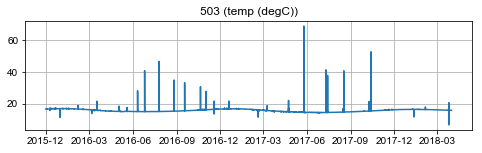

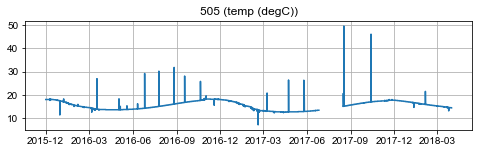

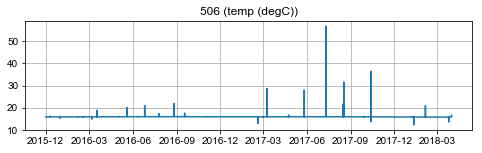

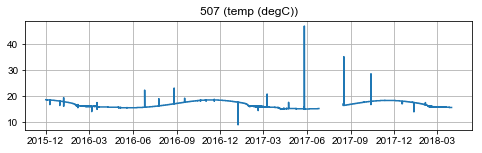

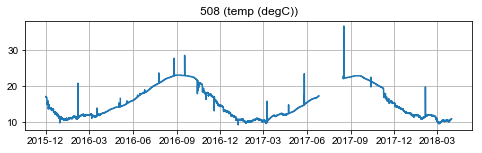

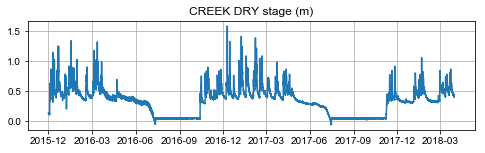

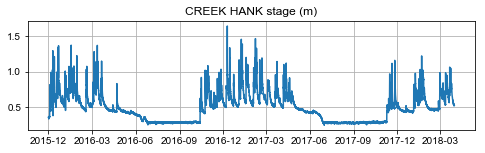

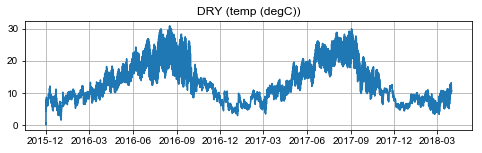

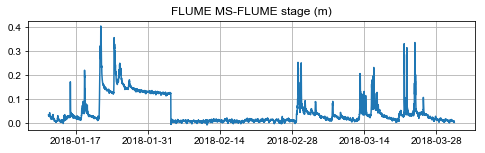

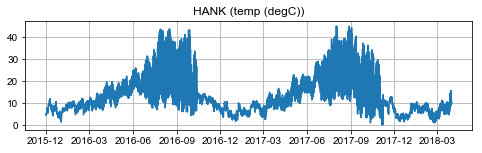

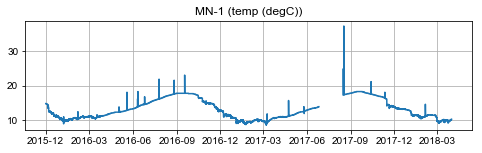

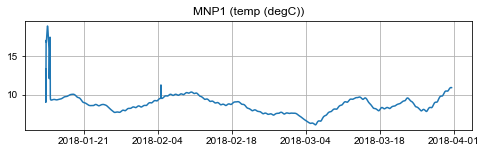

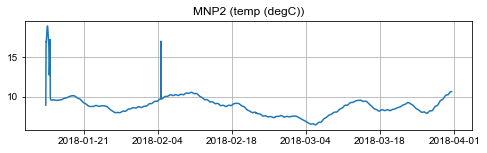

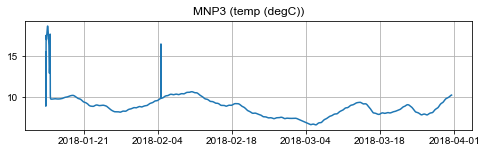

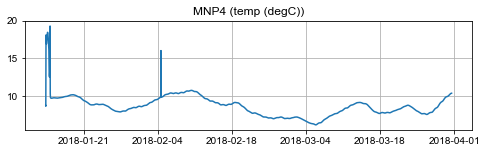

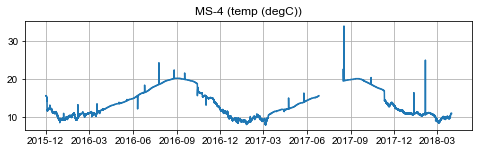

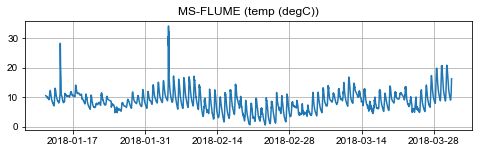

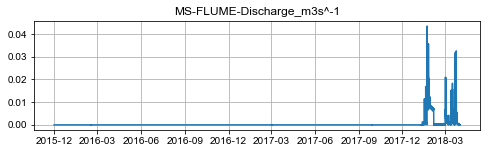

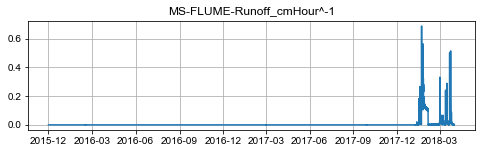

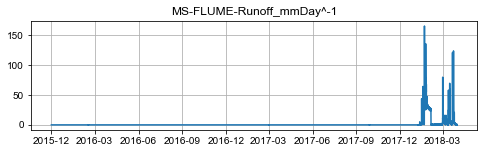

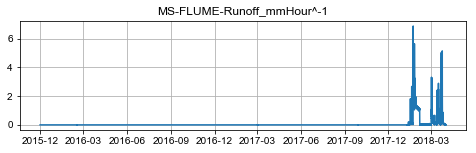

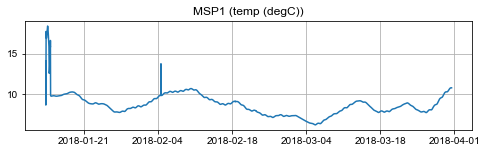

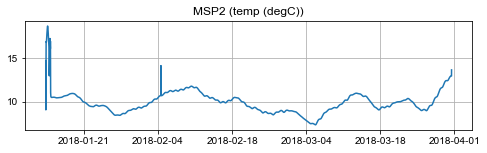

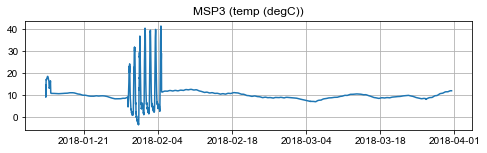

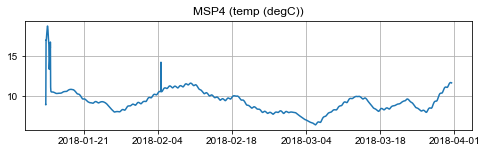

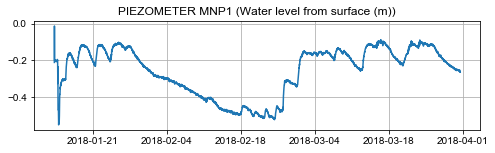

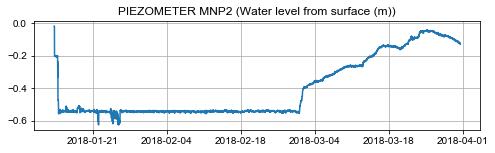

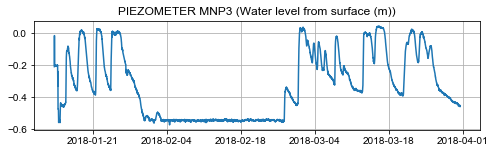

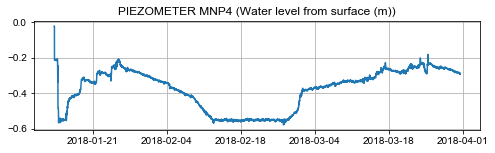

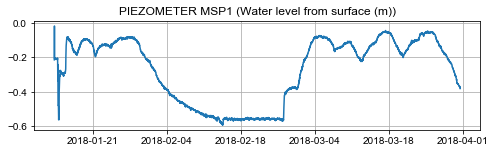

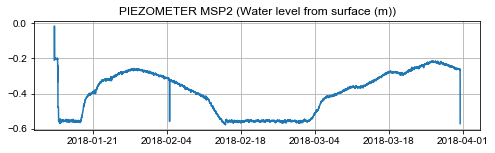

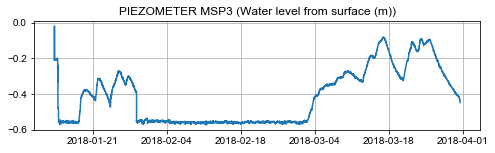

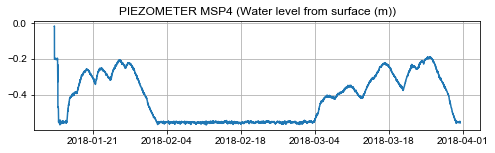

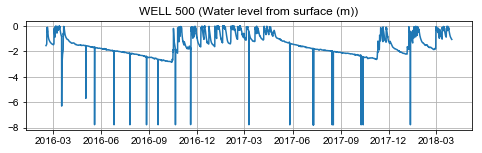

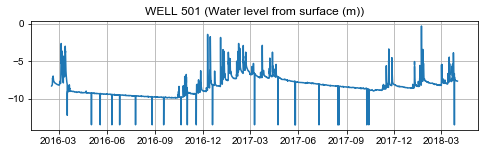

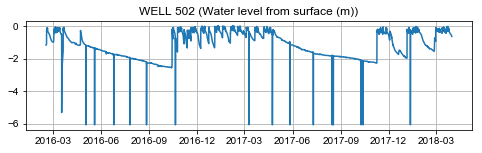

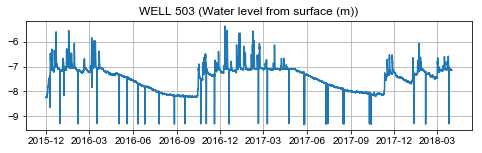

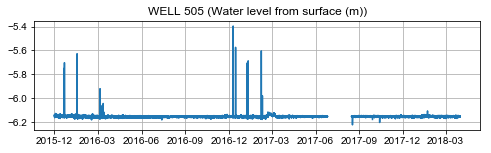

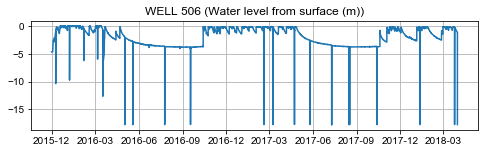

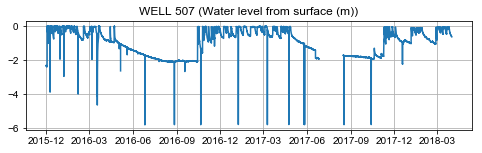

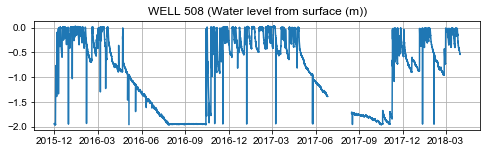

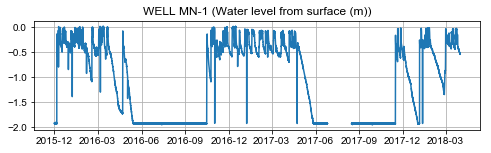

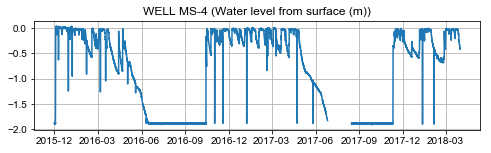

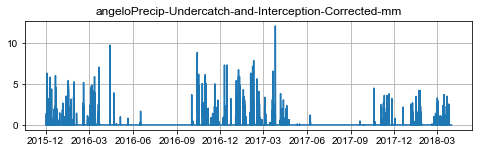

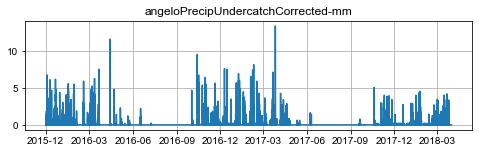

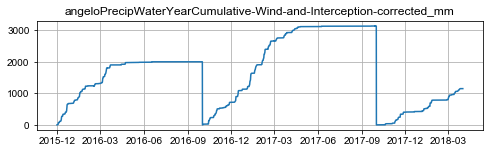

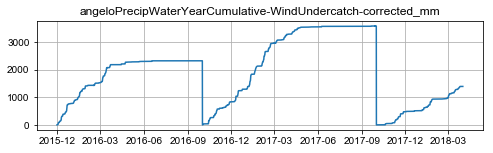

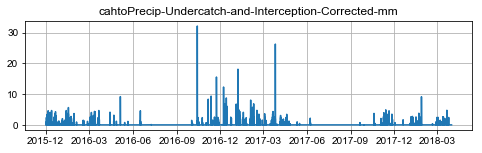

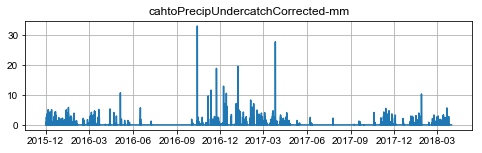

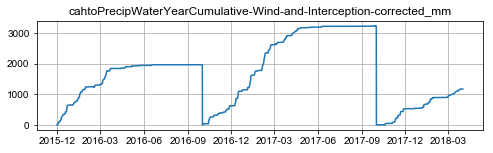

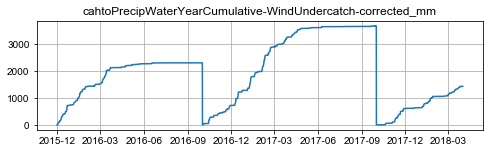

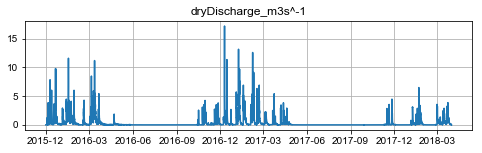

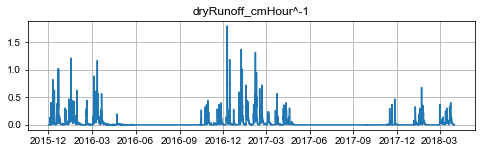

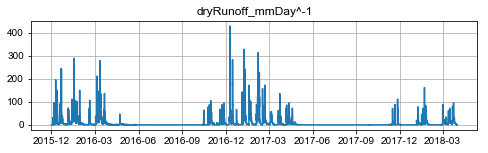

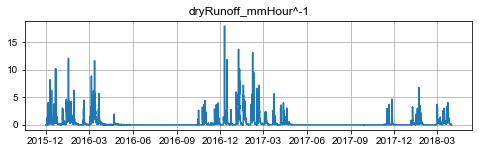

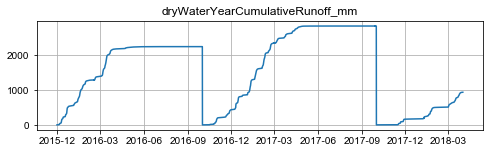

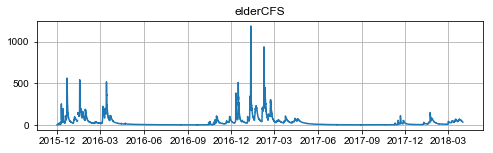

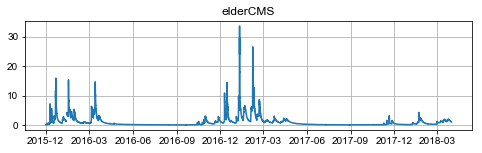

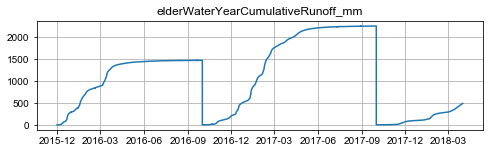

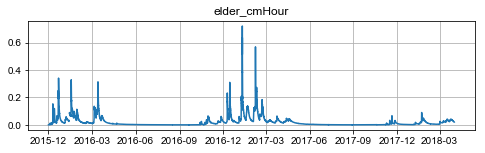

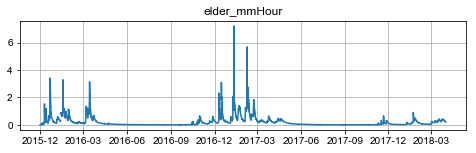

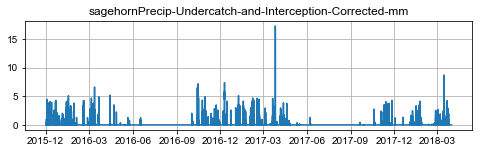

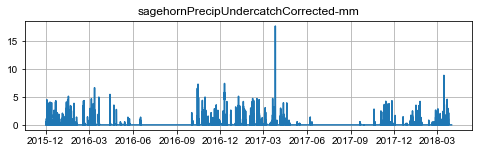

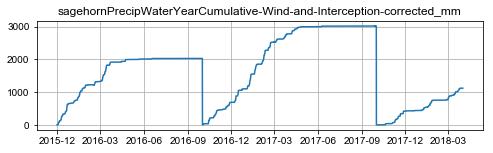

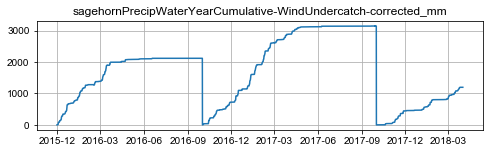

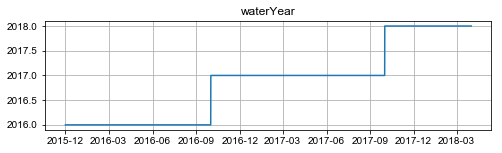

In [109]:
#diagnostic plots:
for column in level4e.columns: 
    plt.subplots(figsize=(8,2))
    plt.plot(level4e.index, level4e[column])
    plt.title(column)
    plt.grid()
    plt.savefig('Data/Output/OutputFigures/'+column+'-allTime.pdf')
    plt.show()

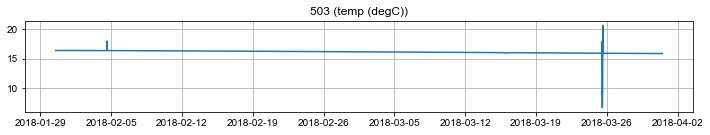

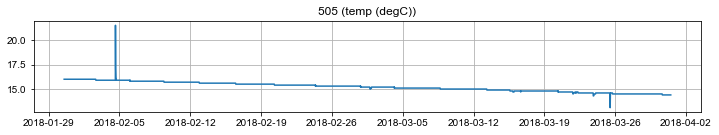

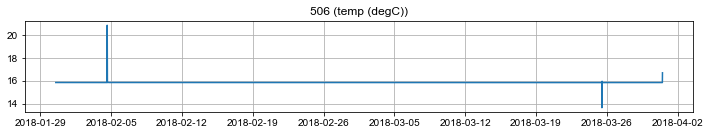

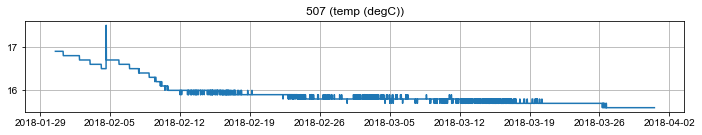

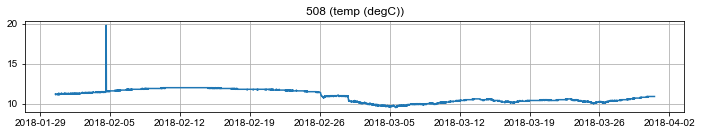

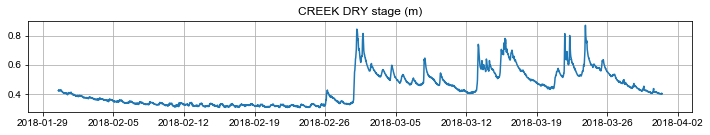

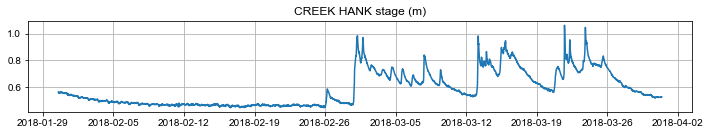

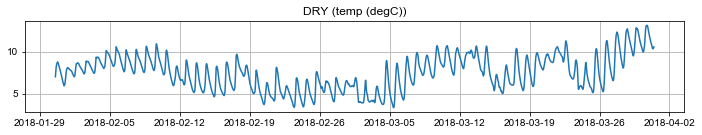

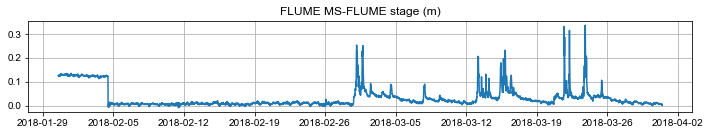

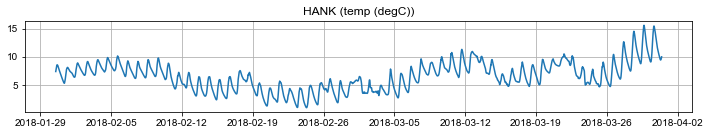

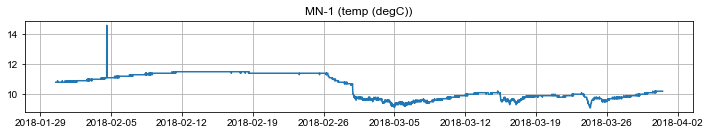

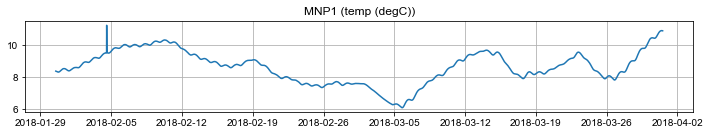

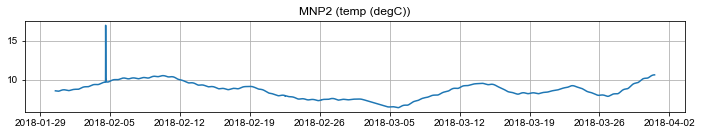

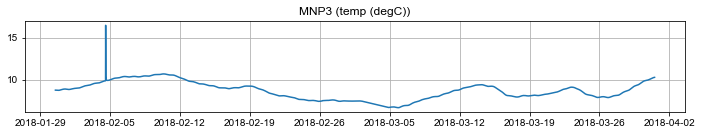

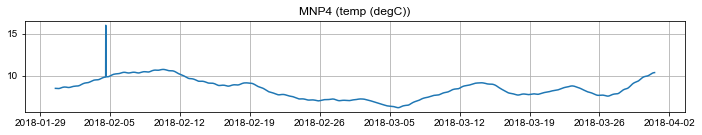

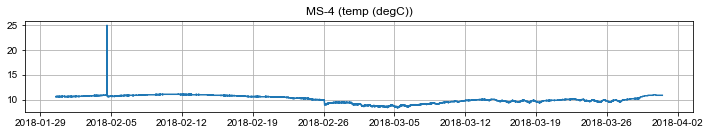

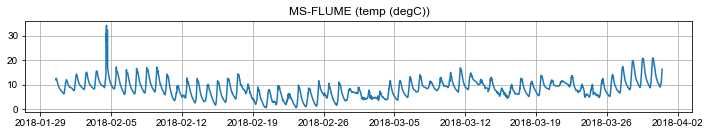

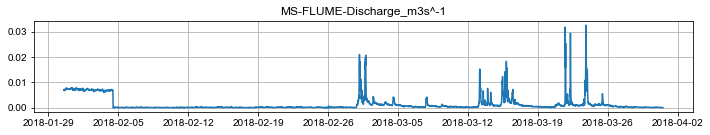

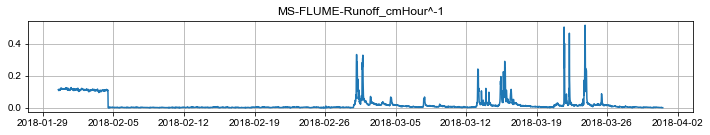

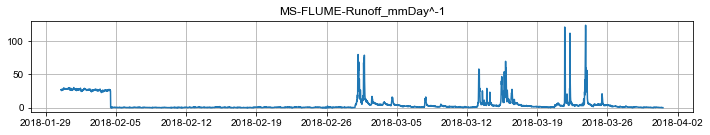

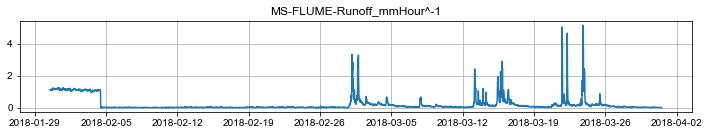

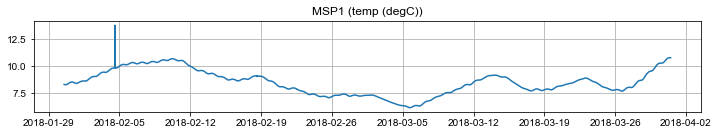

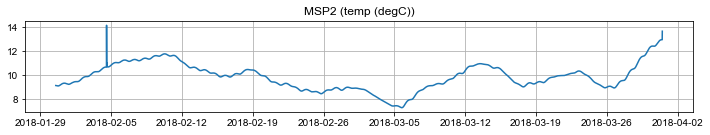

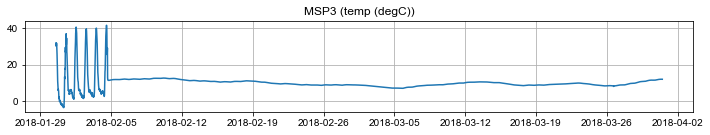

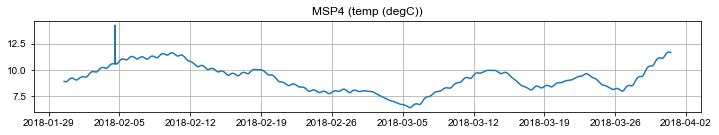

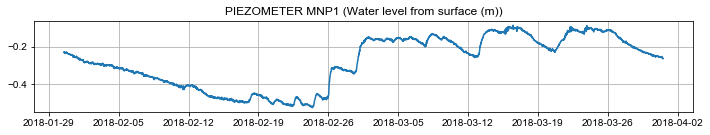

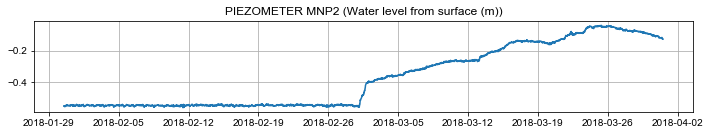

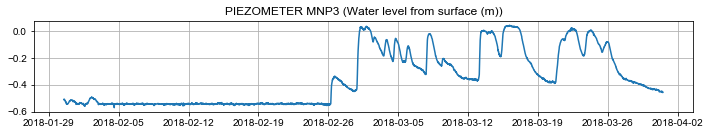

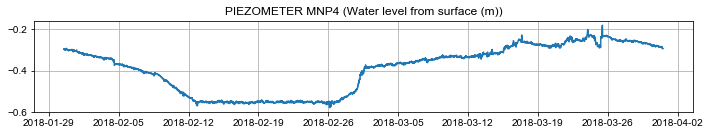

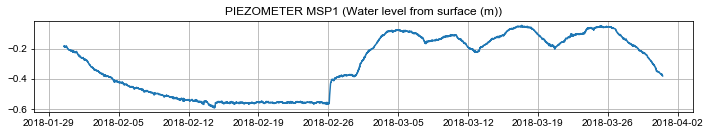

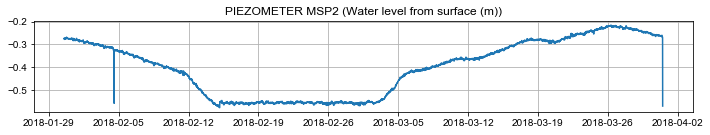

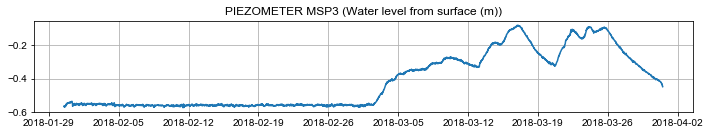

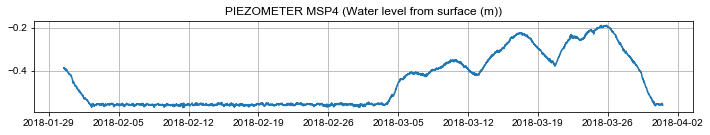

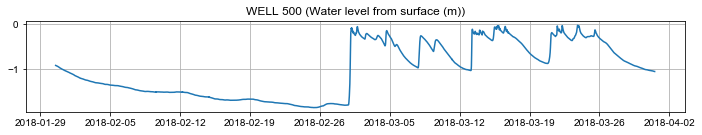

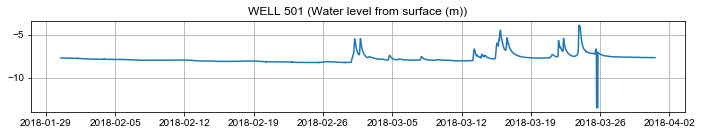

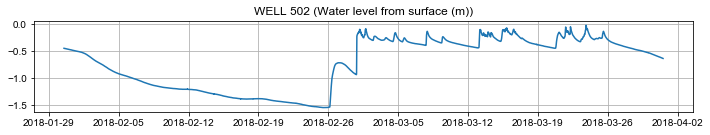

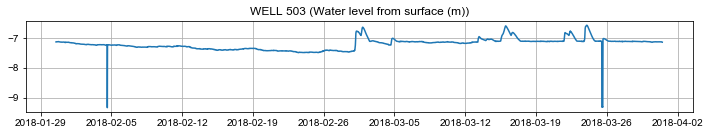

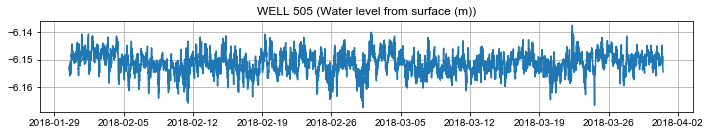

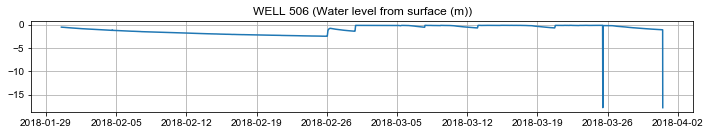

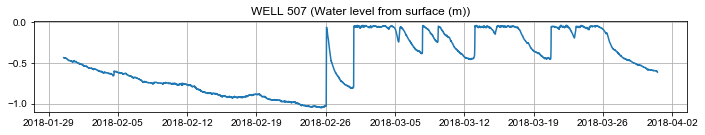

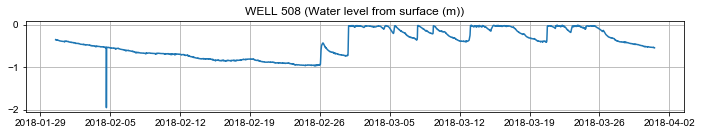

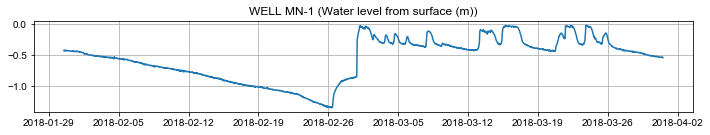

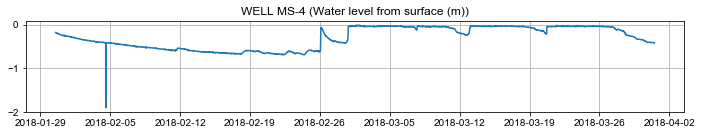

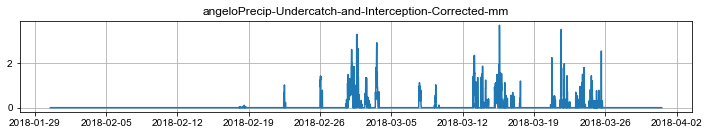

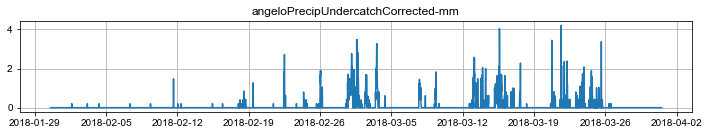

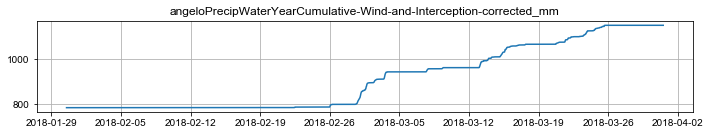

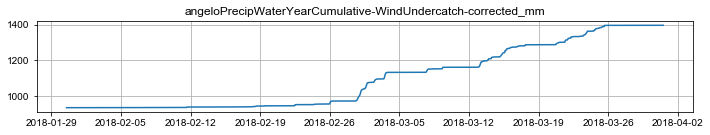

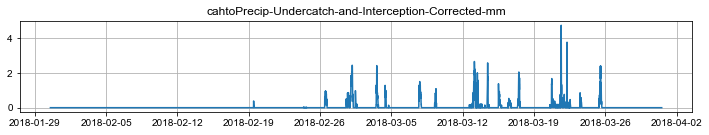

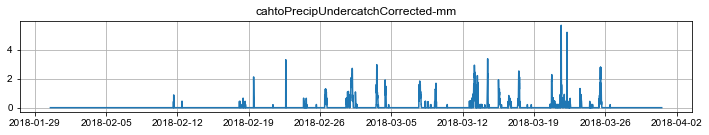

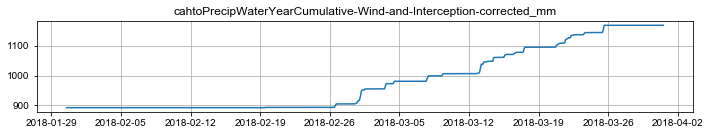

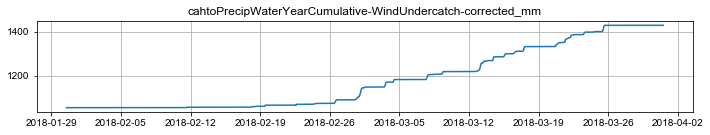

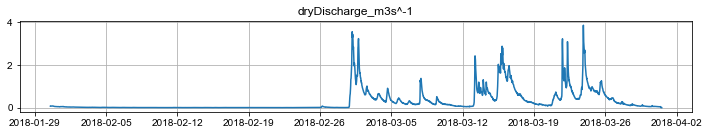

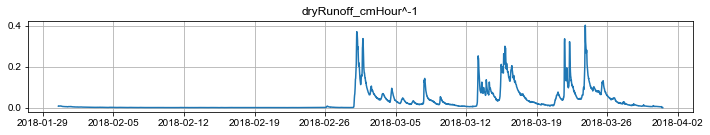

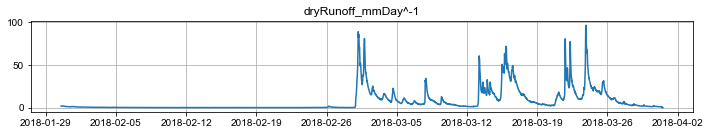

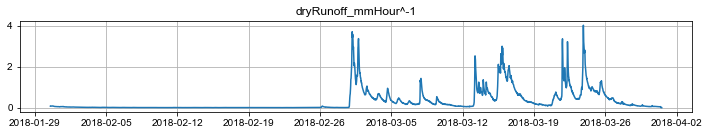

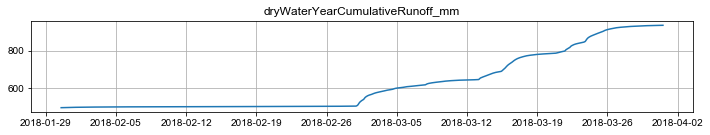

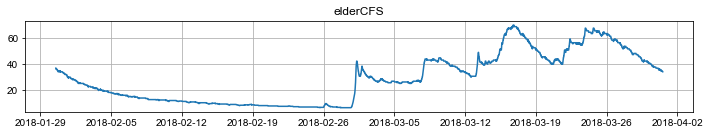

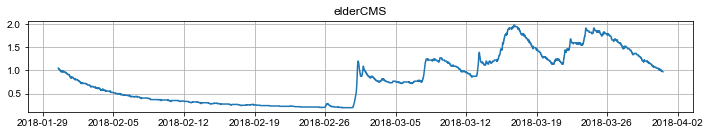

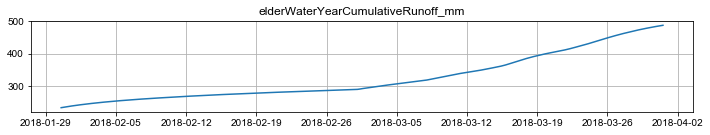

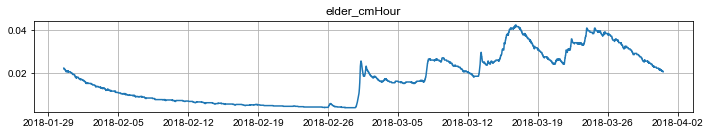

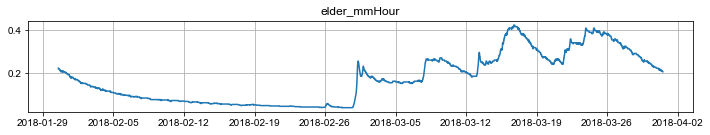

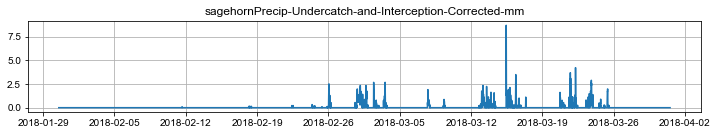

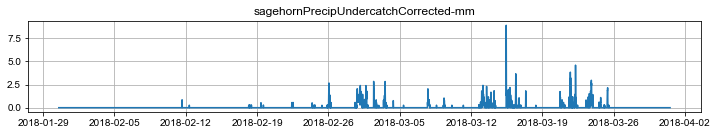

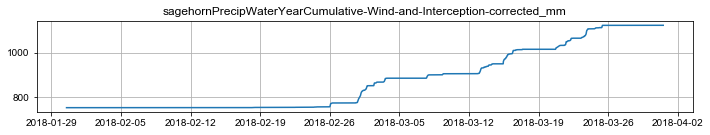

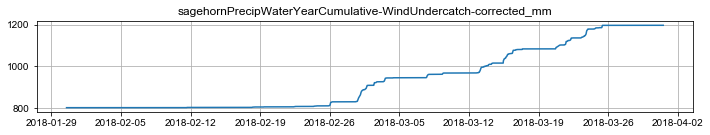

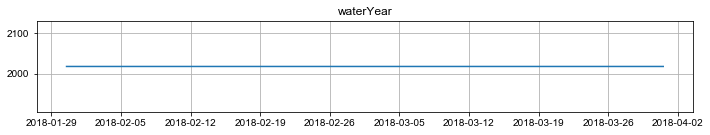

In [111]:
# Plot last two months
plotData = level4e.loc[level4e.index[-1]-Timedelta('60d'):level4e.index[-1]]

for column in plotData.columns: 
    plt.subplots(figsize=(10,2))
    plt.plot(plotData.index, plotData[column])
    plt.title(column)
    plt.grid()
    plt.tight_layout()
    plt.savefig('Data/Output/OutputFigures/'+column+'-lastMonth.pdf')
    plt.show()


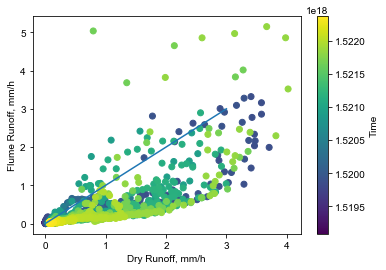

In [112]:
start ='2018-02-20'
stop = '2018-03-29'
plt.scatter(level4e['dryRunoff_mmHour^-1'].loc[start:stop],
            level4e['MS-FLUME-Runoff_mmHour^-1'].loc[start:stop],
           c=level4e.loc[start:stop].index)
plt.xlabel('Dry Runoff, mm/h')
plt.ylabel('Flume Runoff, mm/h')
plt.plot([0,3],[0,3])
plt.colorbar(label='Time')

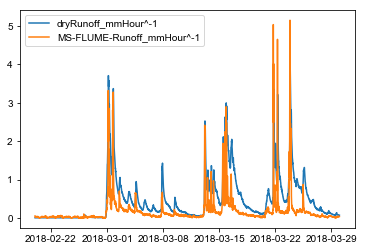

In [113]:
plt.plot(level4e['dryRunoff_mmHour^-1'].loc[start:stop])
plt.plot(level4e['MS-FLUME-Runoff_mmHour^-1'].loc[start:stop])
plt.legend()

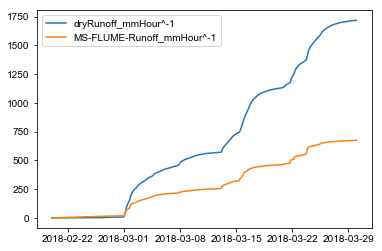

In [114]:
plt.plot(level4e['dryRunoff_mmHour^-1'].loc[start:stop].cumsum())
plt.plot(level4e['MS-FLUME-Runoff_mmHour^-1'].loc[start:stop].cumsum())
plt.legend()